CON RUIDO: {'0': 0.661777, '1': 0.33822300000000005}


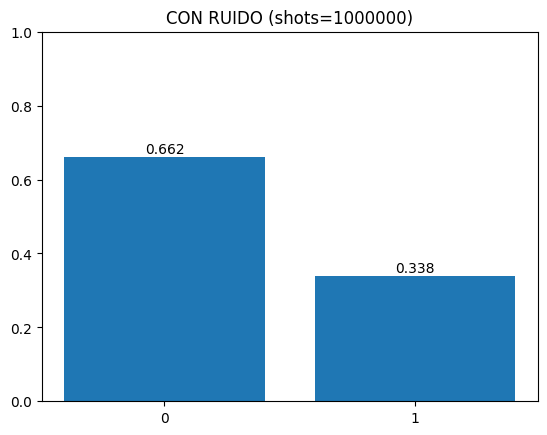

2.8220667839050293


In [2]:
# -*- coding: utf-8 -*-
# Requisitos:
#   pip install "qiskit>=2.1" "qiskit-aer>=0.14" matplotlib
#   (opcional para FAKE_TORINO) pip install qiskit-ibm-runtime

import os, numpy as np, matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendSamplerV2
from collections import Counter
import time
import math

try:
    from qiskit_ibm_runtime.fake_provider import FakeTorino
    HAS_FAKE = True
except Exception:
    HAS_FAKE = False

# --------- Parámetros ---------
USE_NOISE = True
P1 = 3e-4
P2 = 3e-3
PM =  1e-2
SHOTS = 1_000_000
SEED  = 1234

# Inyecta un error Z de prueba (tras el H-in): None, 0, 1, o 2
ERROR_POS = None

def build_noise_model(p1, p2, pm):
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p1,1),
        ['x','y','z','h','s','sdg','t','tdg','rx','ry','rz','sx'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])
    ro = ReadoutError([[1-pm, pm],[pm,1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return noise

def build_circuit():
    """
    Phase-flip (Z) majority coherente (sin estabilizadores):
      - Preparación |ψ> en data[0]
      - Encode: CX(0->1), CX(0->2)
      - H-in: H en data[0..2]  (convierte Z->X)
      - (opcional) Z en data[k] para probar corrección
      - Secuencia mayoría (la misma que X-flip): CX(0->1), CX(0->2), CCX(1,2->0)
      - H-out: H en data[0..2] (vuelve a base computacional)
      - Medir solo data[0] en 'final'
    """
    q_data  = QuantumRegister(3, 'data')
    q_final = ClassicalRegister(1, 'final')
    qc = QuantumCircuit(q_data, q_final)

    # Estado lógico arbitrario (igual que tus scripts)
    qc.ry(2*np.arccos(np.sqrt(2/3)), q_data[0])

    # Encode a 3 qubits
    qc.cx(q_data[0], q_data[1])
    qc.cx(q_data[0], q_data[2])

    # H-in (sándwich de Hadamard de entrada)
    qc.h(q_data[0]); qc.h(q_data[1]); qc.h(q_data[2])

    # (Opcional) inyecta Z para probar la corrección de phase-flip
    if ERROR_POS in (0,1,2):
        qc.z(q_data[ERROR_POS])

    # Misma mayoría coherente que en X-flip
    qc.cx(q_data[0], q_data[1])
    qc.cx(q_data[0], q_data[2])
    qc.ccx(q_data[1], q_data[2], q_data[0])

    # H-out (sándwich de salida)
    qc.h(q_data[0]); qc.h(q_data[1]); qc.h(q_data[2])

    # Medición SOLO del lógico final
    qc.measure(q_data[0], q_final[0])

    return qc

def run_sampler(circ, backend, shots):
    sampler = BackendSamplerV2(backend=backend)
    res = sampler.run([circ], shots=shots).result()[0]
    return Counter(res.join_data().get_counts())

def marginalize(circ, counts, clbit):
    idx, tot = circ.clbits.index(clbit), sum(counts.values())
    p0 = sum(c for k,c in counts.items() if isinstance(k,str) and k[-1-idx]=='0')
    return {'0': p0/tot, '1': 1-p0/tot}

def plot_probs(probs, title):
    plt.bar(probs.keys(), probs.values()); plt.ylim(0,1)
    for x,v in probs.items(): plt.text(x, min(1.0, v+0.02), f"{v:.3f}", ha='center')
    plt.title(title); plt.show()

def main(graficar):
    qc = build_circuit()
    n_threads = max(1, math.floor(os.cpu_count() / 3))

    if graficar == "SIN_RUIDO":
        backend = AerSimulator(method="statevector", seed_simulator=SEED)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED)
        counts = run_sampler(qc_t, backend, SHOTS)
        probs = marginalize(qc_t, counts, qc_t.cregs[-1][0])
        print("SIN RUIDO:", probs)
        plot_probs(probs, f"SIN RUIDO (shots={SHOTS})")

    elif graficar == "CON_RUIDO":
        noise = build_noise_model(P1, P2, PM)
        backend = AerSimulator(method="density_matrix", noise_model=noise, seed_simulator=SEED)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED)
        counts = run_sampler(qc_t, backend, SHOTS)
        probs = marginalize(qc_t, counts, qc_t.cregs[-1][0])
        print("CON RUIDO:", probs)
        plot_probs(probs, f"CON RUIDO (shots={SHOTS})")

    elif graficar == "FAKE_TORINO":
        if not HAS_FAKE:
            raise RuntimeError("Instala qiskit-ibm-runtime para usar FakeTorino.")
        fake = FakeTorino()
        backend = AerSimulator.from_backend(fake, seed_simulator=SEED)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED)
        counts = run_sampler(qc_t, backend, SHOTS)
        probs = marginalize(qc_t, counts, qc_t.cregs[-1][0])
        print("FAKE_TORINO:", probs)
        plot_probs(probs, f"FAKE_TORINO (shots={SHOTS})")

    else:
        raise ValueError("graficar debe ser 'SIN_RUIDO', 'CON_RUIDO' o 'FAKE_TORINO'.")

if __name__ == "__main__":
    inicio = time.time()
    graficar = "CON_RUIDO"  # "CON_RUIDO", "SIN_RUIDO", "FAKE_TORINO"
    main(graficar)
    print(f"Tiempo: {time.time()-inicio:.2f}s")
